In [1]:
%matplotlib inline

In [2]:
import os
import re
import time
import json
import subprocess
from dateutil import parser
from datetime import datetime

import json
import pylab
import numpy as np
from datetime import datetime
from pysurvey.plot import setup, dateticks, hist, minmax, embiggen
from matplotlib.dates import date2num, num2date

In [3]:
hostname = !hostname
assert hostname[0] == 'chargino', 'This is a computer specific notebook'

In [4]:
FILENAME = os.path.expanduser('~/.batlog.dat')
if os.path.exists(os.path.expanduser('~/data/.batlog.dat')):
    FILENAME = os.path.expanduser('~/data/.batlog.dat')

OUTFILENAME = os.path.expanduser('~/data/batterylog/simplelog.json')
PREFIX = '    | |           '
PATTERN = '"(\w+)" = (.+)'

def parse_legacy(value):
    tmp = value.replace('=',':')
    return json.loads(tmp)

def parse_date(line):
    try:
        return time.mktime(parser.parse(line).timetuple())
    except:
        return time.mktime(datetime.fromtimestamp(int(line)).timetuple())

def parse(filename, outfile):
    out = []
    measurement = {}
    with open(filename, 'r') as f:
        for line in f.readlines():
            if line.startswith(PREFIX):
                x = line.replace(PREFIX, '').strip()
                item,value = re.match(PATTERN, x).groups()
                if item == 'LegacyBatteryInfo':
                    tmp = parse_legacy(value)
                    measurement.update(tmp)
                else:
                    measurement[item] = int(value)
            else:
                if len(measurement) > 0:
                    out.append(measurement)
                
                # key = time.mktime(parser.parse(line).timetuple())
                key = parse_date(line)
                measurement = dict(date=key)
    return out

In [5]:
data = parse(FILENAME, OUTFILENAME)

In [6]:
def make():
    tag = 'Voltage'
    tag = 'CurrentCapacity'
#     data = json.load(open(FILENAME,'r'))
    date = date2num([datetime.fromtimestamp(x['date']) for x in data if len(x) > 1])
    amp  = [x[tag] for x in data if len(x) > 1]
    
    damp = np.diff(amp)
    ddate = date[:-1] + np.diff(date)/2.0
    uii = np.where(damp > 2)
    dii = np.where(damp < -2)
    print len(data)
    
    
    plot_params = dict(
        marker = 's',
        markersize=2,
        alpha=0.2,
        linestyle='_',
        markeredgewidth=0,
        markeredgecolor='none',
    )
    
    xr = embiggen(minmax(date), 0.02, 'both')
    yr = [0,7000]
    dyr = [-80,80]
    if np.max(amp) > 7000:
        yr = [0,10000]
        dyr = [-100,100]
    
    setup(figsize=(16,8))
    
    setup(subplt=(2,3,1), autoticks=True,
          title='Last Recorded: {}'.format(num2date(date[-1])),
          xlabel='Date', xr=xr,
          ylabel=tag, yr=yr)
    pylab.plot(date, amp, **plot_params)
    dateticks('%Y-%m-%d')
    
    tmp = date % 7.0
    setup(subplt=(2,3,2), autoticks=True,
          title='Current Date: {}'.format(datetime.now()),
          xlabel='Day of Week', 
          xtickv=np.arange(7), xr=[-0.2,6.2], 
          xticknames='sun mon tue wed thur fri sat'.split(),
          ylabel=tag, yr=yr)
    pylab.plot(tmp, amp, **plot_params)
    
    tmp = (date % 1.0) * 24.0
    setup(subplt=(2,3,3), autoticks=True,
          xlabel='Hour of Day', xr=[-0.4,24.4],
          xtickv=np.arange(0,25,4), xtickrotate=dict(rotation=90, ha='center'),
          xticknames='mid 4am 8am noon 4pm 8pm  mid'.split(),
          ylabel=tag, yr=yr)
    pylab.plot(tmp, amp, **plot_params)
    # dateticks('%Y-%m-%d')
    
    
    
    
    setup(subplt=(2,3,4), autoticks=True, 
          xlabel='Date', xr=xr,
          ylabel='Delta', yr=dyr)
    pylab.plot(ddate, damp, **plot_params)
    dateticks('%Y-%m-%d', ha='center')
    
    
    tmp = (date % 7.0)[:-1]
    setup(subplt=(2,3,5), autoticks=True,
          xlabel='Day of Week',
          xtickv=np.arange(7), xr=[-0.2,6.2], 
          xticknames='sun mon tue wed thur fri sat'.split(),
          ylabel=tag, yr=dyr)
    pylab.plot(tmp, damp, **plot_params)
    hist(tmp[uii], np.linspace(0,7,90), alpha=0.5, norm=dyr[1], filled=True)
    hist(tmp[dii], np.linspace(0,7,90), alpha=0.5, norm=dyr[0], filled=True)
    
    tmp = ((date % 1.0) * 24.0)[:-1]
    setup(subplt=(2,3,6), autoticks=True,
          xlabel='Hour of Day', xr=[-0.4,24.4],
          xtickv=np.arange(0,25,4), xtickrotate=dict(rotation=90, ha='center'),
          xticknames='mid 4am 8am noon 4pm 8pm  mid'.split(),
          ylabel=tag, yr=dyr)
    pylab.plot(tmp, damp, **plot_params)
    hist(tmp[uii], np.linspace(0,24,50), alpha=0.5, norm=dyr[1], filled=True)
    hist(tmp[dii], np.linspace(0,24,50), alpha=0.5, norm=dyr[0], filled=True)
    # dateticks('%Y-%m-%d')
    
    
    
    # pylab.tight_layout()
    setup(hspace=0, wspace=0)
    pylab.show()

153225


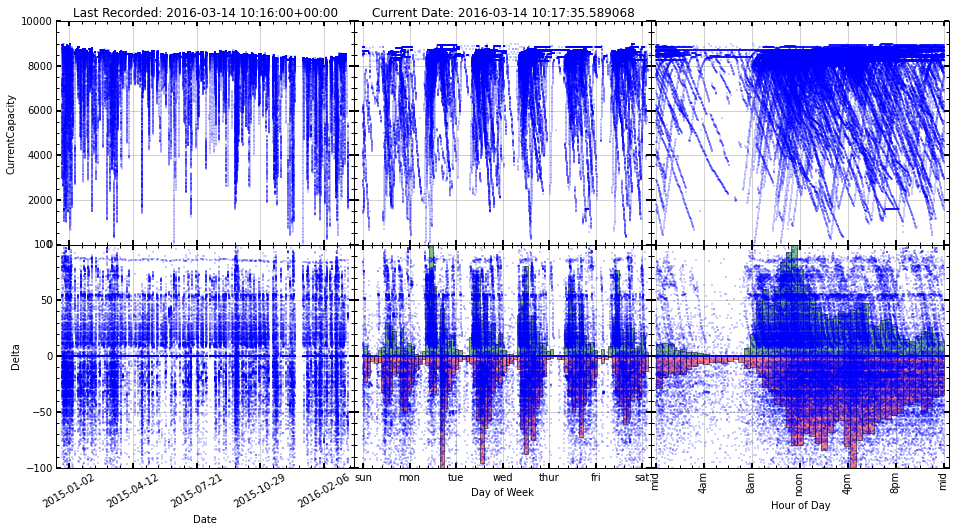

In [7]:
make()